In [126]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

In [127]:
# load calibration error
DATAPATH = '../output_from_datalab/accuracy_estimation_error'
PSEUDOCOUNT = [0.1, 1, 10]
NUM_RUNS = 100
DATASET_LIST = ['imagenet', 'dbpedia', 'cifar100', '20newsgroup', 'svhn', 'imagenet2_topimages'] 
METRIC_LIST = ['weighted_pool_error', 'weighted_online_error', 'unweighted_error', 'pool_ece', 'online_ece']

def get_metric_filename(metric, dataset, pseudo_n, model_type):
    # fix some errors when writing the outputs to files
    if metric in ['pool_ece', 'mce', 'online_ece'] and model_type == 'frequentist':
        return "%s/%s%s_PseudoCount%.1f_runs%d_%s.csv" % (
                DATAPATH, metric, dataset, pseudo_n, NUM_RUNS, model_type)        
    else:
        return "%s/%s_%s_PseudoCount%.1f_runs%d_%s.csv" % (
                DATAPATH, metric, dataset, pseudo_n, NUM_RUNS, model_type)

In [128]:
N_list = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
header = ['dataset', 'metric', 'model_type', 'pseudo_n'] + N_list
results = []

In [129]:
for metric in METRIC_LIST:
    for dataset in DATASET_LIST:
        for pseudo_n in PSEUDOCOUNT:
            params = [dataset, pseudo_n]
            bayesian_result = np.mean(np.genfromtxt(get_metric_filename(metric, dataset, pseudo_n, 'bayesian')
                                                    , delimiter=","), axis=0).tolist()
            frequentist_result = np.mean(np.genfromtxt(get_metric_filename(metric, dataset, pseudo_n, 'frequentist')
                                                       , delimiter=","), axis=0).tolist()
            if len(bayesian_result) < len(N_list):
                bayesian_result.append(-1)
                frequentist_result.append(-1)
            results.append([dataset, metric, 'bayesian', pseudo_n] + bayesian_result)
        results.append([dataset, metric, 'frequentist', 0] + frequentist_result)

In [130]:
results =  pd.DataFrame(results, columns=header)
results.to_csv('../output_from_datalab/results.csv')
results

,dataset,metric,model_type,pseudo_n,10,20,50,100,200,500,1000,2000,5000,10000
0,imagenet,weighted_pool_error,bayesian,0.1,0.122291,0.129304,0.111623,0.078368,0.058884,0.034689,0.024250,0.017499,0.010637,0.007278
1,imagenet,weighted_pool_error,bayesian,1.0,0.090778,0.092889,0.085350,0.066699,0.053854,0.033445,0.023783,0.017309,0.010583,0.007262
2,imagenet,weighted_pool_error,bayesian,10.0,0.044050,0.043833,0.042140,0.038751,0.036592,0.027357,0.020935,0.016057,0.010203,0.007134
3,imagenet,weighted_pool_error,frequentist,0.0,0.225304,0.184999,0.124306,0.081522,0.059803,0.034888,0.024324,0.017529,0.010643,0.007280
4,dbpedia,weighted_pool_error,bayesian,0.1,0.006935,0.007590,0.007533,0.006838,0.005727,0.004882,0.004200,0.003052,0.001873,0.001210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,svhn,online_ece,frequentist,0.0,0.873430,0.874730,0.875612,0.876796,0.873737,0.875105,0.874886,0.874134,0.874030,0.873962
116,imagenet2_topimages,online_ece,bayesian,0.1,0.716438,0.720202,0.718056,0.720913,0.720313,0.720115,0.721704,0.721561,0.721629,0.720800
117,imagenet2_topimages,online_ece,bayesian,1.0,0.724180,0.725591,0.720736,0.722403,0.721266,0.720594,0.721962,0.721704,0.721682,0.720823
118,imagenet2_topimages,online_ece,bayesian,10.0,0.738038,0.736825,0.732120,0.731944,0.729088,0.724931,0.724492,0.723071,0.722238,0.721115


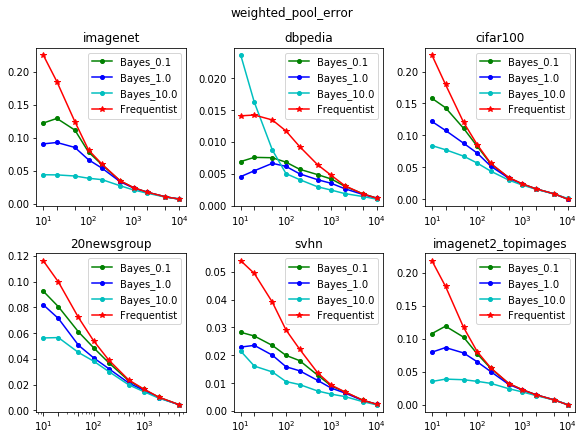

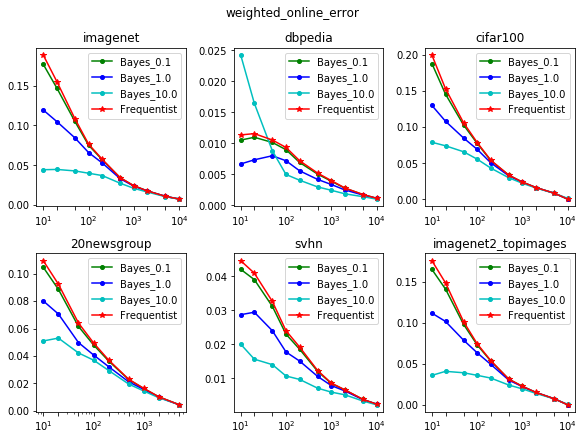

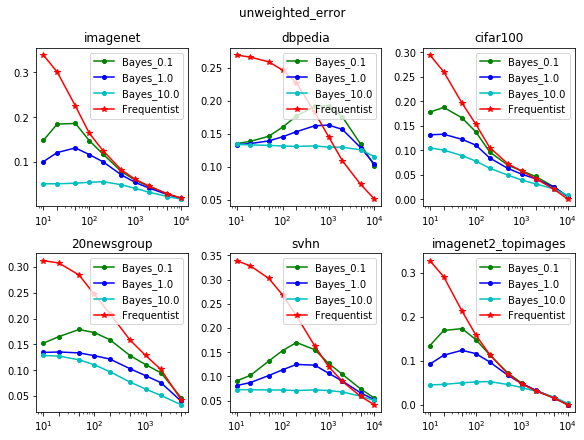

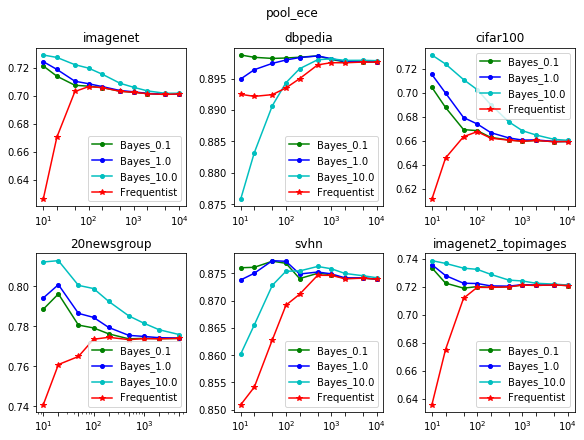

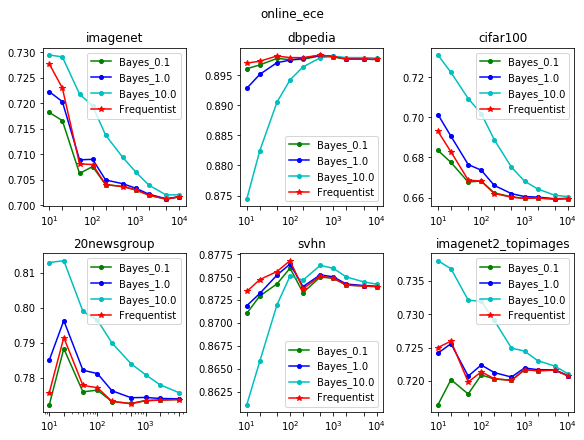

In [131]:
for metric in METRIC_LIST:
    figname = '../figures/accuracy_estimation_error/%s.pdf' % metric
    fig, ax = plt.subplots(2, 3, figsize=(8, 6), constrained_layout=True)
    for idx, dataset in enumerate(DATASET_LIST):
        ax[idx//3, idx% 3].set_title('%s' % dataset)
        if dataset == '20newsgroup':
            x = N_list[:-1]
        else:
            x = N_list
        result_slice = results[(results.metric == metric) & (results.dataset == dataset)]
        y_frequentist = result_slice[result_slice.model_type == 'frequentist'][x].values[0]
        result_slice = result_slice[result_slice.model_type == 'bayesian']
        y_bayesian_01 = result_slice[result_slice.pseudo_n == 0.1][x].values[0]
        y_bayesian_1 = result_slice[result_slice.pseudo_n == 1.0][x].values[0]
        y_bayesian_10 = result_slice[result_slice.pseudo_n == 10.0][x].values[0]
        ax[idx//3, idx% 3].semilogx(x, y_bayesian_01, 'o', ls='-', ms=4, color = 'g', label='Bayes_0.1')
        ax[idx//3, idx% 3].semilogx(x, y_bayesian_1, 'o', ls='-', ms=4, color = 'b', label='Bayes_1.0')
        ax[idx//3, idx% 3].semilogx(x, y_bayesian_10, 'o', ls='-', ms=4, color = 'c', label='Bayes_10.0')
        ax[idx//3, idx% 3].semilogx(x, y_frequentist, '*', ls='-', ms=6, color = 'r', label='Frequentist')
        ax[idx//3, idx% 3].set_xticks(x)
        ax[idx//3, idx% 3].legend()
    plt.suptitle(metric)
    fig.savefig(figname)